<a href="https://colab.research.google.com/github/kibutan/freeCodeCamp/blob/main/machine-learning-with-python/fcc_book_recommendation_knn_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
# from scipy.sparse import csr_matrix
import scipy.sparse
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip


--2021-11-02 02:31:36--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  29.1MB/s    in 0.9s    

2021-11-02 02:31:37 (29.1 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [59]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

[手順](https://forum.freecodecamp.org/t/book-recommendation-knn-system/412976/6#:~:text=After%20being%20stuck,reason%20to%20pass.)

Groupby(User).countでユーザごとのカウント数が出せるから、それとdf_rateingをマージ出来る方法が内科検討した。が、Df_groupオブジェクトとなるため、マージができなかった。[このへｎ](https://stackoverflow.com/questions/24980437/pandas-groupby-and-then-merge-on-original-table)は多分やってることが違う。

はじめからDF_ratingに[Countsをつける方法](https://stackoverflow.com/questions/35809098/how-to-merge-pandas-value-counts-to-dataframe-or-use-it-to-subset-a-dataframe#:~:text=df%5B%27brand_count%27%5D%3D%20df.brand.map(df.brand.value_counts()))で有れば提示されていた。
以下3セルはその名残

In [48]:
groupby = df_ratings.groupby("user")
count = groupby.count()

In [ ]:
# count.query("isbn >= 200 and rating >= 100").sort_values("counts_rate")

In [ ]:
# pd.merge(df_ratings,groupby)

DF_ratingsに直接カウントした情報を乗せる

In [64]:
#はじめに、200未満の投稿数のユーザ、100未満の評価数の本を削除する。 
#Userの数をcounts_user列として表示
#https://stackoverflow.com/questions/35809098/how-to-merge-pandas-value-counts-to-dataframe-or-use-it-to-subset-a-dataframe#:~:text=df%5B%27brand_count%27%5D%3D%20df.brand.map(df.brand.value_counts())
df_ratings["counts_user"] = df_ratings.user.map(df_ratings.user.value_counts())
df_ratings["counts_rate"] = df_ratings.isbn.map(df_ratings.isbn.value_counts())

In [76]:
#評価100件以上の本を評価が少ない順で
df_ratings.query("counts_rate >= 100").sort_values("counts_rate")

,user,isbn,rating,counts_user,counts_rate
428128,102275,0449203794,0.0,234,100
940864,227705,0425189864,0.0,356,100
941298,227836,0312966806,0.0,123,100
1088512,260944,0385424736,8.0,169,100
715559,173415,0425189864,0.0,589,100
...,...,...,...,...,...
1113097,266865,0971880107,0.0,393,2502
833253,201521,0971880107,2.0,10,2502
917419,223608,0971880107,2.0,18,2502
213212,49634,0971880107,4.0,2,2502


In [77]:
#評価200件以上のユーザを評価が少ない順で
df_ratings.query("counts_user >= 200").sort_values("counts_user")

,user,isbn,rating,counts_user,counts_rate
1059108,252827,0749919949,8.0,200,1
1059015,252827,0340617179,9.0,200,1
1059016,252827,0340653833,0.0,200,4
1059017,252827,0340682272,10.0,200,27
1059018,252827,034068948X,0.0,200,41
...,...,...,...,...,...
49862,11676,0440407974,7.0,13602,2
49863,11676,0440408652,4.0,13602,9
49864,11676,0440409241,0.0,13602,3
49866,11676,0440412463,8.0,13602,3


In [79]:
df_ratings = df_ratings.query("counts_user >= 200 and counts_rate >= 100")

In [81]:
df_ratings.sort_values("counts_user")

,user,isbn,rating,counts_user,counts_rate
118143,26883,067976402X,0.0,200,614
418734,99955,0425132951,0.0,200,106
418735,99955,042513525X,0.0,200,139
418744,99955,0440225701,0.0,200,379
418756,99955,0446604844,0.0,200,101
...,...,...,...,...,...
48746,11676,0385336179,7.0,13602,160
48761,11676,0385420161,0.0,13602,134
48762,11676,038542017X,8.0,13602,121
48766,11676,0385424728,0.0,13602,122


In [82]:
df_ratings.sort_values("counts_rate")

,user,isbn,rating,counts_user,counts_rate
489089,116599,0312966806,0.0,863,100
1053443,251613,0449203794,0.0,1124,100
649686,157247,0425151867,5.0,346,100
684088,166596,0425151867,0.0,1258,100
920083,224349,0060916508,0.0,1005,100
...,...,...,...,...,...
170558,36907,0971880107,0.0,224,2502
1000631,240144,0971880107,0.0,881,2502
998352,239594,0971880107,0.0,300,2502
213015,49460,0971880107,0.0,237,2502


いささか件数が少ない気もするが、ユーザ数評価数でDropができている用に見える。

In [5]:
# ユーザ数200以上、isbn100件以上の本をDFにするが実行に6分かかる。
# testdf = df_ratings.groupby(["isbn"]).filter(lambda group: group['user'].count() > 200 and group['isbn'].count() > 100 )

KeyboardInterrupt: ignored

In [ ]:
# testdf = testdf.groupby(["isbn"]).filter(lambda group: group['isbn'].count() > 100)

[k近傍法でアニメのレコメンドをつくる](https://www.codexa.net/collaborative-filtering-k-nearest-neighbor/)

In [ ]:
df_books.describe()

In [ ]:
round(df_ratings,2)

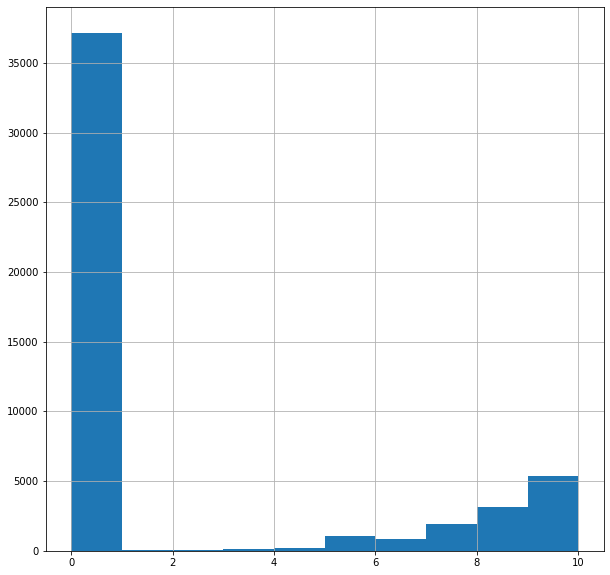

In [83]:
df_ratings["rating"].hist(bins = 10,figsize = (10,10))

In [ ]:
# df_ratings = df_ratings.query('rating >= 1.0')

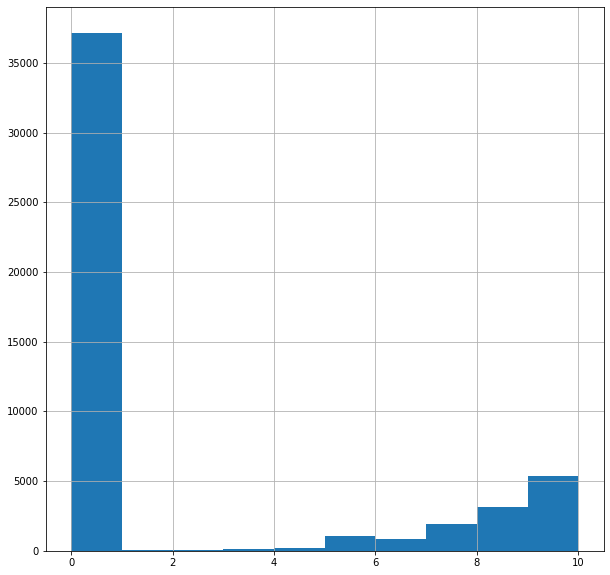

In [84]:
df_ratings["rating"].hist(bins = 10,figsize = (10,10))

In [85]:
df_ratings.isnull().sum()

user           0
isbn           0
rating         0
counts_user    0
counts_rate    0
dtype: int64

[df.merge](https://note.nkmk.me/python-pandas-merge-join/)

Now merge df_ratings with df_books.

In [89]:
df_books

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger
271375,0525447644,From One to One Hundred,Teri Sloat
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271377,0192126040,Republic (World's Classics),Plato


In [87]:
# mergedf = df_ratings.merge(df_books)
mergedf = df_ratings.merge(df_books)


In [101]:
mergedf

,user,isbn,rating,counts_user,counts_rate,title,author
0,277427,002542730X,10.0,497,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,901,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,13602,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,1351,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,709,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
...,...,...,...,...,...,...,...
49512,238864,0399149325,0.0,353,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49513,251843,0399149325,1.0,338,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49514,253821,0399149325,0.0,337,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49515,265115,0399149325,0.0,1221,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell


<!-- User 200 Books 200 の後マージしたやつは 64102 rows  *5Columns -->

In [ ]:
# mergedf.query("user" > 200)

In [ ]:
testdf

In [102]:
# testdf = testdf.drop_duplicates(["title","user"])
mergedf = mergedf.drop_duplicates(["title","user"])


In [103]:
mergedf

,user,isbn,rating,counts_user,counts_rate,title,author
0,277427,002542730X,10.0,497,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,901,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,13602,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,1351,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,709,171,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
...,...,...,...,...,...,...,...
49512,238864,0399149325,0.0,353,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49513,251843,0399149325,1.0,338,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49514,253821,0399149325,0.0,337,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49515,265115,0399149325,0.0,1221,113,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell


In [104]:
piv = mergedf.pivot(index='title', columns='user', values='rating').fillna(0)

In [105]:
piv

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
sparse_mat = scipy.sparse.csr_matrix(piv.values)

In [96]:
sparse_mat

<673x888 sparse matrix of type '<class 'numpy.float32'>'
	with 12419 stored elements in Compressed Sparse Row format>

In [107]:
df_sparse_test = pd.DataFrame.sparse.from_spmatrix(sparse_mat)

In [115]:
neigh = NearestNeighbors(metric="cosine",n_neighbors= 5,algorithm="brute")
model = neigh.fit(df_sparse_test)

In [ ]:
# mergedf.describe()

[pd.drop()](https://note.nkmk.me/python-pandas-drop/)

In [ ]:
# mergedf.drop(["title", "author"],axis = 1)

[pd.pivot()によるメモリ枯渇を防ぐ術](https://career-tech.biz/2020/02/22/knn-movie-recommend/)

In [ ]:
# mergedf = mergedf.sample(frac = 0.01)
# user_categorical = pd.api.types.CategoricalDtype(categories=sorted(mergedf.user.unique()),ordered = True)
# isbn_categorical = pd.api.types.CategoricalDtype(categories=sorted(mergedf.isbn.unique()),ordered = True)
# row =mergedf.user.astype(user_categorical) .cat.codes
# col =mergedf.isbn.astype(isbn_categorical) .cat.codes

In [ ]:
# sparse_matrix = scipy.sparse.csr_matrix((mergedf["rating"],(row,col)), shape = (user_categorical.categories.size, isbn_categorical.categories.size))

In [ ]:
# user_categorical

In [ ]:
# isbn_categorical

In [ ]:
# test = pd.DataFrame({"A": pd.arrays.SparseArray([0, 1])})

In [ ]:
# test

In [ ]:
# arr = np.random.randn(10)
# arr[2:-2] = np.nan
# ts = pd.Series(pd.arrays.SparseArray(arr))

In [ ]:
# arr

In [ ]:
# sparse_matrix.shape

In [ ]:
# sparse_ndarray = sparse_matrix.resize(sparse_matrix.shape)


In [ ]:
# df_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)

In [ ]:
# df_sparse

In [ ]:
# neigh = NearestNeighbors(n_neighbors= 5,algorithm="auto")
# model = neigh.fit(sparse_mat)

In [ ]:
# mergedf = mergedf.sample(frac = 0.01)

In [ ]:
# mergedf

In [ ]:
# model_test = neigh.fit(mergedf[["user","rating"]])

In [ ]:
# distances, indices = model.kneighbors([["21440","10"]], 3)

In [ ]:
# distances

In [ ]:
# indices

In [ ]:
# pd.arrays.SparseArray(sparse_matrix)

In [ ]:
# train_pivot_sparce = pd.SparseDataFrame(sparce_matrix,index = userID_categorical.categories,columns  = isbn_categorical.categories,default_fill_value = 0, dtype = "int")
# train_pivot_sparse = pd.DataFrame(pd.arrays.SparseArray(sparse_matrix),index = userID_categorical.categories,columns  = isbn_categorical.categories,)


In [ ]:
# book_pivot = mergedf.pivot(index = "isbn", columns = "user" , values = "rating").to_sparse(fill_value=0).info(memory_usage='deep')

In [ ]:
# book_pivot.head()

In [ ]:
# add your code here - consider creating a new cell for each section of code

In [ ]:
# knn = neigh = NearestNeighbors()
# model = neigh.fit(df_ratings[["rating","user"]])

In [ ]:
# neigh.kneighbors_graph([["0.5","276790"]])

In [ ]:
# plt.plot(df_ratings['rating'],df_ratings['user'],df_ratings['isbn'],"o")


In [151]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  distance, indice = model.kneighbors(piv.iloc[piv.index == book].values.reshape(1,-1),n_neighbors=6 )
  recommended_books =[[]]
  recommend = []
  for i in range(0, len(distance.flatten())):
    if i == 0:
      print("title this",piv[piv.index == book].index[0])
      recommended_books[0] = piv[piv.index == book].index[0]
    else:
      recommend.append([piv.index[indice.flatten() [i]],distance.flatten()[i]])

  # model
  # recomend_bools.append(Near 5 books )
  recommend.sort(key=lambda x: x[1],reverse = True)#数字の大きい順に並べ替え
  recommended_books.append(recommend)
  print(recommended_books)
  return recommended_books

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [152]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

title this Where the Heart Is (Oprah's Book Club (Paperback))
["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
title this Where the Heart Is (Oprah's Book Club (Paperback))
["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉


[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]

In [135]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

[['The Queen of the Damned (Vampire Chronicles (Paperback))'], [['Catch 22', 0.7939835], ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566], ['Interview with the Vampire', 0.73450685], ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384], ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]


[['The Queen of the Damned (Vampire Chronicles (Paperback))'],
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]